## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp    #Package to extract the dataset

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 212 kB 48.3 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [9]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
#Se usa tokenizer para representar cada palabra de los tweets
#como un número para poder entrenar así la red con esos datos
#Es decir, convertir palabras en números, a cada una se le a-
#signa un token único.

#Se usan las 10000 palabras más comunes, las que no están ahí
#entonces se les asigna un unknown token (UNK)
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [12]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [13]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

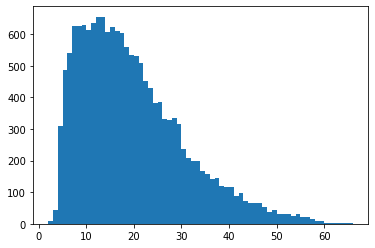

In [14]:
#Se usa padding porque el modelo necesita que todos los ejemplos
#tengan el mismo tamaño, pero hasta ahora cada tweet tiene una can-
#tidad de palabras distintas, entonces cada dato tiene tamaño distinto
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [27]:
#Para truncarlos si tienen más de 50 palabras
#Se paddean con ceros sino
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [17]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [18]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [19]:
classes = set(labels)
print(classes)

{'anger', 'love', 'surprise', 'sadness', 'joy', 'fear'}


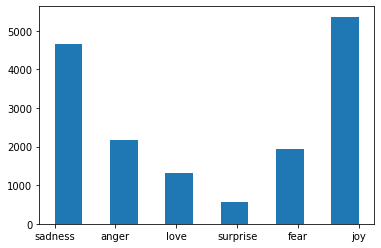

In [20]:
plt.hist(labels, bins=11)
plt.show()

#Hay un class imbalance problem porque hay muchos datos para 
#sadness y joy, pero no muchos para surprise y love

In [21]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [22]:
class_to_index

{'anger': 0, 'fear': 5, 'joy': 4, 'love': 1, 'sadness': 3, 'surprise': 2}

In [23]:
index_to_class

{0: 'anger', 1: 'love', 2: 'surprise', 3: 'sadness', 4: 'joy', 5: 'fear'}

In [24]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [25]:
train_labels = names_to_ids(labels)
print(train_labels[0])

3


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [29]:
#LSTM: Long Short Term Memory es una Recurrent Neural Net que le 
#permite a la red recordar las cosas que necesita para mantener el
#contexto, pero puede olvidar las cosas que ya no aplican
#LSTM agrega un estado a la RNN para resolver los problemas de la RNN

model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

#Bidirectional Layer permite que el contexto pueda fluir en ambos sentidos

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

#Como los labels no están en one-hot-encoding entonces usamos sparse para la
#clasificación multi-clases

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [31]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [32]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [33]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 40s 60ms/step - loss: 1.2522 - accuracy: 0.5008 - val_loss: 0.7418 - val_accuracy: 0.7210
Epoch 2/20
500/500 [==============================] - 28s 56ms/step - loss: 0.5311 - accuracy: 0.7887 - val_loss: 0.5650 - val_accuracy: 0.8180
Epoch 3/20
500/500 [==============================] - 28s 56ms/step - loss: 0.3113 - accuracy: 0.8947 - val_loss: 0.4616 - val_accuracy: 0.8540
Epoch 4/20
500/500 [==============================] - 28s 56ms/step - loss: 0.2210 - accuracy: 0.9276 - val_loss: 0.4080 - val_accuracy: 0.8650
Epoch 5/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1654 - accuracy: 0.9492 - val_loss: 0.4206 - val_accuracy: 0.8705
Epoch 6/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1279 - accuracy: 0.9605 - val_loss: 0.3996 - val_accuracy: 0.8795
Epoch 7/20
500/500 [==============================] - 27s 55ms/step - loss: 0.1072 - accuracy: 0.9672 - val_loss: 0.4439 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

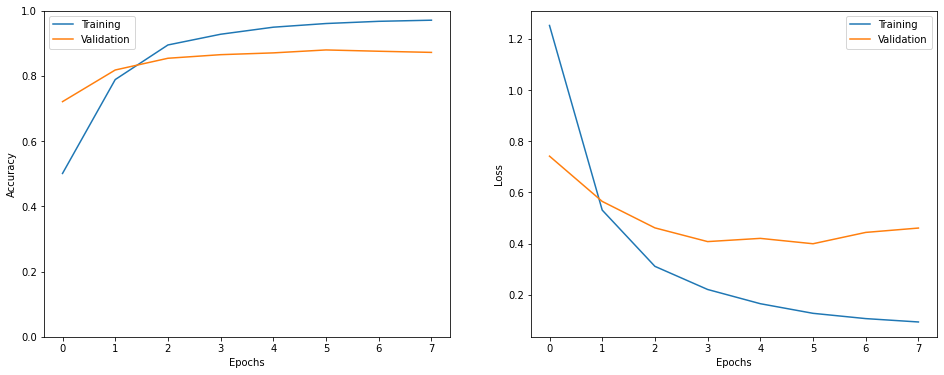

In [34]:
show_history(h)

In [35]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [36]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.4746 - accuracy: 0.8700


In [41]:
i = random.randint(0, len(test_labels) - 1)

#Original:
print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

#Predicción:
p = model.predict(np.expand_dims(test_seq[i], axis=0))[0] #Se expande para hacer que el input tenga el tamaño adecuado
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ', pred_class)

Sentence:  i feel affectionate toward him
Emotion:  love
Predicted Emotion:  love


In [48]:
preds = np.argmax(model.predict(test_seq),axis=1) #predict_classes fue eliminado

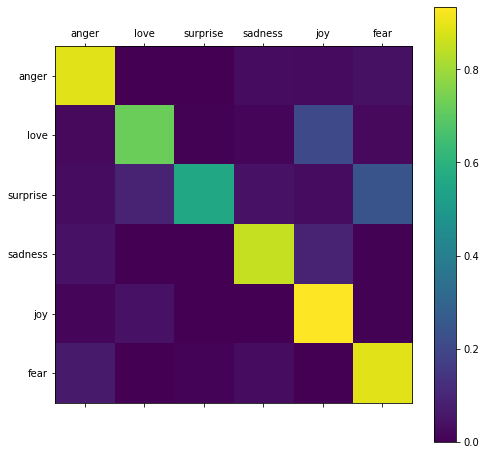

In [49]:
show_confusion_matrix(test_labels, preds, list(classes))

In [50]:
#Si hubieran más ejemplos para las clases que están sub-representadas
#entonces se tendrían mejores resultados, es decir, los errores se
#deben principalmente al class imbalance